## Project 3: Anomaly detection and Predictive maintenance for industrial devices

Jelin Raphael Akkara, 2072064\
Kiamehr Javid, 2084294\
Davide Checchia, 2078232

## Defining Modules, Setting up Cluster

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
from dask.distributed import progress, wait, performance_report
from collections import Counter
import dask
from math import ceil, floor
from functools import reduce
from dask import delayed
import zipfile
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from random import shuffle
#import s3fs

In [2]:
from dask.distributed import LocalCluster, Client

cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62428,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.35 GiB
Comm: tcp://127.0.0.1:62455,Total threads: 3
Dashboard: http://127.0.0.1:62456/status,Memory: 3.84 GiB
Nanny: tcp://127.0.0.1:62431,


In [2]:
from dask.distributed import Client

# use the provided master
client = Client('tcp://10.67.22.71:8786')
client

<Client: 'tcp://10.67.22.71:8786' processes=3 threads=12, memory=23.25 GiB>

## Cleaning Data

### Obtaining Dataset

In [ ]:
# Extract zipped file into VM storage

# path = '/opt/data/Devices.zip'

# with zipfile.ZipFile(path, 'r') as zip:
#     #zip.printdir()
#     zip.extractall('/opt/data/')

#### Reading from the AWS Bucket

In [3]:
#VM Cluster: Read from bucket

#CSV File with 5M rows
# df = dd.read_csv('s3://MAPD-B-2023-GR18/subset_5e6rows_FULL.csv',
#         storage_options={
#         'key':'12936735a1734e2bbfa8ae79e513e64e',
#         'secret':'6db296138c8a4c3384ab63e69b5220da',
#         'client_kwargs': {
#         'endpoint_url': 'https://cloud-areapd.pd.infn.it:5210/',
#         'verify': False }})

#Parquet folder with 142M rows
df = dd.read_parquet('s3://MAPD-B-2023-GR18/device_all_parquet/',
        storage_options={
        'key':'12936735a1734e2bbfa8ae79e513e64e',
        'secret':'6db296138c8a4c3384ab63e69b5220da',
        'client_kwargs': {
        'endpoint_url': 'https://cloud-areapd.pd.infn.it:5210/',
        'verify': False }})

df.head()

,when,hwid,metric,value
0,1601510485159,SW-065,SA4,0.0
1,1601510485159,SW-065,SA3,0.0
2,1601510485159,SW-065,SA2,0.0
3,1601510485159,SW-065,S34,0.0
4,1601510485159,SW-065,S33,1.0


In [3]:
path = '~/MAPD_dataset.csv'

df = dd.read_csv(path, 
                    dtype={#'when': str, 
                       'hwid': str,
                       'metric': str,
                       'value': float},
                    blocksize = 8.517e7 )

#### Reading from Local System

In [176]:
#Local Cluster

#Read parquet File
#Files: file_065, file_088, file_106, file_115

device_name = 'SW-088'
device_num = device_name.split('-')[1]
path = rf'E:\Academics\UniPD\Courses\Semester_2\MAPD_2\Project\SW_{device_num}_parquet'
#path = rf'E:\Academics\UniPD\Courses\Semester_2\MAPD_2\Project\device_all_parquet'

df = dd.read_parquet(path)
print(len(df))

df.head(5)

42095692


,when,hwid,metric,value
id,,,,
1,1601510458920,SW-088,SW,1.0
2,1601510458920,SW-088,S1,0.0
3,1601510458920,SW-088,S2,0.0
4,1601510458920,SW-088,S3,125.0
5,1601510458920,SW-088,S5,0.0


#### Equal Repartitioning, Converting to Parquet

Devices and their number of rows:
- SW-065 : 27576413
- SW-088 : 42095692
- SW-106 : 26187749
- SW-115 : 46242916

When filtering a partitioned dataframe and a partition comes out empty, the partition does not get removed.  Instead it remains as an empty partition.  The function below will remove such empty partiitons.

In [4]:
#Removes empty partitions
def remove_empty_partitions(df):

    #Gets the list of each partition lengths
    part_lens = list(df.map_partitions(len).compute())
    if 0 not in part_lens: return('No empty partitions')

    df_delayed = df.to_delayed()
    df_delayed_new = list()
    part_empty = None
    
    for pos, n in enumerate(part_lens):

        #Get metadata of emtpy partition
        if n == 0:
            part_empty = df.get_partition(pos)    
        
        #If non-emtpy partition, then append
        else:
            df_delayed_new.append(df_delayed[pos])  

    df_removed = dd.from_delayed(df_delayed_new, meta=part_empty)
    return df_removed

The function below repartitions a dataframe into equal partitions, given the desired number of partitions.  This is done by splitting the dataframe size into almost equal sizes, which is used to create divisions and then make equal partitions.

In [5]:
#Creates equal-sized partitions
def create_equal_parts(df_check, nparts, divs = None):

    #Defines new column of sequential counts as index
    df_check['id'] = 1
    df_check['id'] = df_check['id'].cumsum()
    df_check = df_check.set_index('id')

    #If divisions not provided, we calculate them
    if not divs:
        #List of almost equal sizes created and shuffled
        num = len(df_check)
        size_list = [num // nparts + (1 if x < num % nparts else 0)  for x in range (nparts)]
        shuffle(size_list)

        #Divisions defined using shuffle size_list
        divs = np.cumsum(size_list)
        divs = list( np.insert(divs, 0, 1) )    
    
    #Dataframe repartitioned using divisions
    df_repart = df_check.repartition(divisions = divs)
    return (df_repart)
    

In [6]:
#Filter Dataframe to one device, create equal partitions, convert to parquet files
def get_df_repart(df, device_name, nparts, save_parquet = False):

    #For the whole dataframe with 142M rows
    if device_name == 'All' and save_parquet:

        name_func = lambda x: f'all-{x}.parquet'
        file_path = rf'E:\Academics\UniPD\Courses\Semester_2\MAPD_2\Project\all_parquet'

        df.to_parquet(file_path, name_function=name_func)

        return ('Finished Creating Parquet Folder for Whole Dataset')


    #Filters Dataframe to only one device
    if isinstance(device_name, list):
        query_string = f'hwid in {device_name}'
    else:
        query_string = f'hwid in ["{device_name}"]'

    df_fil = df.query(query_string)

    #Remove emtpy partitions
    df_removed = remove_empty_partitions(df_fil)

    #Repartition to equal partitions
    df_repart = create_equal_parts(df_removed, nparts)

    if save_parquet:

        #Save as parquet file
        name_function = lambda x: device_name + f"-{x}.parquet"
        device_int = 'SW_' + device_name.split('-')[1]
        #file_path = rf'E:\Academics\UniPD\Courses\Semester_2\MAPD_2\Project\{device_int}__parquet'

        df_repart.to_parquet(file_path, name_function=name_function)

        return('Finished Creating File for ' + device_name)
    
    return (df_repart)

In [7]:
#Check Partition Size splitting

nrows_065 = 27576413
nrows_088 = 42095692
nrows_106 = 26187749
nrows_115 = 46242916

num = nrows_065 + nrows_106
nparts = 36

size_list = [num // nparts + (1 if x < num % nparts else 0)  for x in range (nparts)]
shuffle(size_list)

print(f'Minimum Partition Size: {min(size_list)}, \nMaximum Partition Size: {max(size_list)}')

Minimum Partition Size: 1493448, 
Maximum Partition Size: 1493449


In [8]:
#Get device dataframe without converting to parquet
device_name = ["SW-065", "SW-106"]
nparts = 36

path = rf'C:\Users\Admin\Documents\GitHub\PhysicsOfData_courses\MAPD_B\Project\Plots\{device_name}_{nparts}.html'

with performance_report(filename = path):

    #Get device dataframe and/or save as parquet files
    df = get_df_repart(df, device_name = device_name, nparts = nparts, 
                            save_parquet = False).persist()

In [9]:
partition_lengths = df.map_partitions(len).compute()
print(max(partition_lengths), min(partition_lengths))

1493450 1493448


#### Removing Metrics, Obtaining Metric List and Counts

In [177]:
#Removes unwanted metrics
df = df[~df['metric'].str.contains('E5|E6|ComError')]   

#In case dataframe is for one device
df = df.drop(columns=['hwid'])

In [178]:
#Obtains unique metrics used
metric_list = df['metric'].unique().compute()
metric_list = np.array(metric_list)
metric_list

array(['SW', 'S1', 'S2', 'S3', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11',
       'S15', 'S16', 'S17', 'S19', 'S25', 'S33', 'S34', 'S35', 'S37',
       'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49',
       'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S63', 'S64', 'S69',
       'S70', 'P1', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P15',
       'P16', 'P17', 'P18', 'SA1', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6',
       'SA7', 'SA8', 'SA9', 'SA10', 'SA11', 'SA12', 'S71', 'S72', 'S73',
       'S80', 'S81', 'S83', 'S86', 'S90', 'S94', 'S97', 'S100', 'S101',
       'S102', 'S106', 'S107', 'S108', 'S109', 'S110', 'S112', 'S113',
       'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125',
       'S126', 'S127', 'S128', 'S129', 'S159', 'S158', 'S157', 'S154',
       'S151', 'S147', 'S143', 'S140', 'S138', 'S137', 'S130', 'S171',
       'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180',
       'S181', 'S183', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206',
    

In [179]:
#Obtains metric counts
metric_counts = df['metric'].to_bag().frequencies(sort=True)
metric_counts = df['metric'].value_counts().compute()
metric_counts

metric
SW      639869
S46     323043
S70     323043
S25     323043
S33     323043
         ...  
S167    316811
S170    316811
S205    316810
A9         305
A5         217
Name: count, Length: 132, dtype: Int64

### Normalizing Time Stamps

#### Obtaining Time Bin Value

In this section, we are interested in finding the optimal time interval size, which will allow us to group the dataframe in uniform intervals.  We find that the optimal bin size is 200 seconds, where all the metrics occur 97% of the time in each bin.  

In order to find the optimal time interval size, we choose a time value and check if each metric occurs in each bin (mode = 'presence') and how often it occurs (mode = 'counts').  We accept the least possible time bin size such that each metric occurs a decent amount (say 97%) per bin. /

Counting the presence (or counts) for each metric is done in three steps, which are parallelized:

- Mapping Phase: For each dataframe partition, we define a pandas dataframe that records the presence (counts) of each metric in each bin (Shape: (n_bins, n_metrics)).  We then define the bin numbers covered by the partition.  Iterating for each bin value, we detect the presence (or counts) of each metric in the pandas dataframe.  This updated dataframe is then returned.  Thus, for each partition, we have a pandas dataframe that is returned after this phase.

- Reduce Phase 1:  In this phase, we intend to get a final pandas dataframe that covers the presence (or counts) of metrics for all partitions (for the whole data).  In order to do this, we take a pair of pandas dataframes and take the logical OR of the dataframes for mode = 'presence' (or add the dataframes when mode = 'counts').  This is repeated by taking pairs and reducing it until we arrive at a final dataframe with all the updated values.

- Reduce Phase 2: Here, we intend to calculate the mean occurrence (or counts) for each metric in all bins.  A pandas series is returned.

All the above functions are called from a master function (get_mean_percs), which returns the pandas series with mean occurrence (counts) per metric.

In [180]:
def mapping_ddf_to_pdf_parallel(df_part, mode, n_bins, t_min, bin_size):        # Updates the dict_bins and dict_metrics_count to keep track of presence and counts of metrics

    pdf = pd.DataFrame(np.zeros((n_bins, len(metric_list))))

    t_min_part = df_part['when'].min()       #Minimum time of partitioned df_part 
    t_max_part = df_part['when'].max()       #Maximum time of partitioned df_part

    t_min_part_bin = np.floor( (t_min_part - t_min) / bin_size ).astype(int)       #Gets bin number of t_min_part
    t_max_part_bin = np.floor( (t_max_part - t_min) / bin_size ).astype(int)       #Gets bin number of t_max_part

    bin_indices = [i for i in range(t_min_part_bin, t_max_part_bin + 1)]      #Gets the range of bins covered from t_min_part_bin till t_max_part_bin

    for bin_ind in bin_indices:         

        t_low = t_min + (bin_ind * bin_size)        #The lower limit of the time bin window:  Note the time step is bin_size
        t_high = t_low + bin_size                   #The upper limit of the time bin window

        df_part_fil = df_part[(df_part['when'] >= t_low) & (df_part['when'] <= t_high)]     #Filters df_part down to the time bin window range
        metrics_present = df_part_fil['metric'].unique()                                    #Gets the unique metrics present in window

        if mode == 'presence':
            pdf.iloc[bin_ind] = np.isin(metric_list, metrics_present).astype(float)

        elif mode == 'counts':
            metrics_count = df_part_fil['metric'].value_counts()                 #Gets counts of metrics in window

            pdf.iloc[bin_ind] = np.array([metrics_count[m] if m in metrics_present else 0.0 for m in metric_list]).astype(float)

    return pdf

In [181]:
def reduce_pdf_to_pdf(pdf_part_1, pdf_part_2, mode):

    if mode == 'presence':        
        pdf_reduced = pdf_part_1.astype(int) | pdf_part_2.astype(int)
        return pdf_reduced
    
    elif mode == 'counts':
        pdf_reduced = pdf_part_1 + pdf_part_2
        return pdf_reduced
    
    else: return

In [182]:
def reduce_pdf_to_series(pdf, mode):
    if mode == 'presence':
        reduce_series = pdf.apply(np.mean, axis=0)
        return reduce_series
    elif mode == 'counts':
        reduce_series = pdf.apply(np.mean, axis=0)
        return reduce_series
    else: return

In [183]:
#Get mean percentages of metric occurrence (mode = 'presence') / mean of metric counts (mode = 'counts')
def get_mean_percs(df, bin_size, mode='presence' , plot_graph=False):

    #Define bin_size in terms of UNIX timestamp positions
    bin_size = bin_size * 1000
    t_max, t_min = dask.compute(df['when'].max(), df['when'].min())

    n_bins = int( (t_max - t_min) / (bin_size) ) + 1

    #Pandas Dataframe for reference in meta
    pdf_ref = pd.DataFrame(np.empty((n_bins, len(metric_list)), dtype=float))

    #Mapping phase: Takes in partition and return pandas dataframe with updated metric presence/counts - each partition result is a pandas df
    result_mapped_presence = df.map_partitions(lambda df_part: mapping_ddf_to_pdf_parallel(df_part, mode=mode, n_bins=n_bins, t_min=t_min, bin_size=bin_size), meta=pdf_ref)

    #Drops the index column, converts the partitions to a list of delayed objects (which is later converted to a dask bag)
    #This wraps each partition as a delayed object, thus ensuring its structure when it is put in a dask bag
    delayed_list_presence = result_mapped_presence.map_partitions(lambda x: [x.reset_index(drop=True)]).to_delayed()

    #The list of delayed objects are put in a dask bag, after which the tree-reduce operation is carried out using fold function - returns a bag Item
    result_reduced_presence = db.from_delayed(delayed_list_presence).fold(lambda x, y: reduce_pdf_to_pdf(x, y, mode=mode))

    #Compute result to pandas dataframe
    result_presence = result_reduced_presence.compute()
    metric_presence = result_presence.mean(axis=0)

    print(f'Average metric {mode}: Min = {min(metric_presence)}, Max = {max(metric_presence)}')

    #Visualize graph
    if plot_graph:
        display(result_reduced_presence.visualize(collapse_outputs=True, optimize_graph = True))

    return (metric_presence)

In [ ]:
#Mode options: ['presence', 'counts']
pdf_mean = get_mean_percs(df, bin_size = 200, mode='counts', plot_graph=True)

#### Grouping and Aggregation

Now, that we have the optimal time bin value from the previous section, we move on to group and aggregate the dataframe.  Since the metrics vary in datatype (integer, binary, decimals), we need to define an aggregation that is meaningful to each type of data.  We define a custom aggregation function as below:

- For integers: We take the maximum of the grouped integer values.
- For Decimals: We take the mean of the grouped decimal values.
- For Alarms: We consider the logical OR of the 6, 7, 8 bits of the alarm's binary representation. 

In [184]:
#Gets a list of integers and returns the logical OR for the list
def bwo_list(b):
    res = 0
    for i in range(len(b)):
        if np.isnan(b[i]): b[i] = 0
        res = res | bwo_string(b[i])
    return(res)

#Gets an integer and returns the logical OR of its 6,7,8 binary bits
def bwo_string(b):
    res = 0
    if np.isnan(b): return 0
    b = format(int(b), '016b')[7:10]

    for i in range(len(b)):
        res = res | int(b[i])
    
    return(res)

#Aggregation Function
def aggr(x, func_dict, default_function):
    metric = x.iloc[0, :]['metric'] #Gets the grouping metric
    vals = np.array(x['value'])     #Gets the grouped values

    func = func_dict.get(metric , default_function) #Gets the corresponding aggregation function for the metric
    res = func(vals)                                #Aggregated result
    return(res)

In [185]:
#Returns functions to be used for aggregation
def get_aggr_funcs():

    #Variables with integer values
    # int_vars = ['E4', 'E5', 'E6', 'P1', 'P15', 'P2', 'S1', 'S11', 'S112',
    #                 'S113', 'S114', 'S115', 'S117', 'S118', 'S123', 'S127',
    #                 'S130', 'S15', 'S16', 'S169', 'S17', 'S170', 'S171', 
    #                 'S172', 'S173', 'S174', 'S175', 'S176', 'S179', 'S183',
    #                 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25',
    #                 'S33', 'S34', 'S35', 'S5', 'S53', 'S54', 'S55', 'S56', 'S57', 
    #                 'S63', 'S64', 'S7', 'S73', 'S8', 'S97', 'SA1', 'SA10', 'SA11',
    #                 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9']

    # alarm_vars = ['A5', 'A9']

    int_vars = ['E4', 'E5', 'E6', 'P1', 'P15', 'P2', 'S1', 'S11', 'S112',
                'S113', 'S114', 'S115', 'S117', 'S118', 'S123', 'S127',
                'S130', 'S15', 'S16', 'S169', 'S17', 'S170', 'S171', 
                'S172', 'S173', 'S174', 'S175', 'S176', 'S179', 'S183',
                'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25',
                'S33', 'S34', 'S35', 'S5', 'S53', 'S54', 'S55', 'S56', 'S57', 
                'S63', 'S64', 'S7', 'S73', 'S8', 'S97']

    alarm_vars = ['A5', 'A9', 
                    'SA1', 'SA2', 'SA3', 'SA4', 
                    'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SA10', 'SA11', 'SA12']
    
    #Defines dictionary for aggregation functions for each metric, along with a default function
    int_func = np.max
    int_dict = {m : int_func for m in int_vars}
    alarm_dict = {alarm : bwo_list for alarm in alarm_vars}

    func_dict = int_dict | alarm_dict
    default_function = np.mean

    return(func_dict, default_function)

In [186]:
def group_and_agg(df, bin_size, mode='device', plot_graph=False):

    bin_size = bin_size * 1000
    df['when'] = ( df['when'] - df['when'].min() ) // bin_size

    func_dict, default_function = get_aggr_funcs()

    if mode == 'device':
        #Multi-Index sample for meta reference
        sample_ind_vals = [[0, 0], ['a', 'b']]
        multi_ind = pd.MultiIndex.from_arrays(sample_ind_vals, names=["when", "metric"])

        #Grouping by and Aggregation to fixed time bins
        grouped_df = df.groupby(['when','metric']).apply(lambda x: aggr(x, func_dict, default_function), meta = pd.Series(name = 'value', index = multi_ind)).to_frame()
    
    elif mode == 'whole':
        #Multi-Index sample for meta reference
        sample_ind_vals = [[0, 0], ['a', 'b'], ['a', 'b']]
        multi_ind = pd.MultiIndex.from_arrays(sample_ind_vals, names=["when", "metric", "hwid"])

        #Grouping by and Aggregation to fixed time bins
        grouped_df = df.groupby(['when','metric','hwid']).apply(lambda x: aggr(x, func_dict, default_function), meta = pd.Series(name = 'value', index = multi_ind)).to_frame()
    
    else: return('Invalid Entry: Please select one of these - ["device", "whole"]')

    if plot_graph:
        display(grouped_df.visualize(optimize_graph=True, collapse_outputs=True))
    return(grouped_df)

In [187]:
bin_size = 600
mode = 'device'

path = rf'C:\Users\Admin\Documents\GitHub\PhysicsOfData_courses\MAPD_B\Project\Plots\Grouping_Data\Grouping_{device_name}.html'

with performance_report(filename = path):

    grouped_df = group_and_agg(df, bin_size, 
                                mode = mode, 
                                plot_graph = False).persist()

In [188]:
grouped_df.head()

value
when metric       
0    P1        0.0
     P10     450.0
     S107    224.0
     S172      1.0
     S55       0.0

## Task 1: Anomaly Detection for engines

### Preparing the dataframe

In this section, we get the grouped dataframe and identify all possible anomaly events in it.  When considering a single device, we do this as follows:

- Method to detect possible anomalies (join_vals):  We are interested in the fluctuations occurring in each engine of a device.  High frequency fluctuations are a possible anomaly event.  In order to identify such events, we first filter the dataframe to only the four engines.  A way to detect fluctuations in any of the four engines is to consider the four engines to occupy a state defined by four values, similar to a state in phase space.  Any change in any one of the engines is a change in the collective state.  Thus, we define the collective state by concatenating the four binary engine values and considering the corresponding integer representation.  A change in the integer corresponds to a change in either of the engine values.

- Grouping Engines:  Using the method defined above, we group the four engine states at each time bin using the method.  Thus, at each time bin, we have a corresponding integer that refers to the collective engine state.  

- Detecting Fluctutations:  For detecting fluctuations, we define another column that is the integer column shifted one cell below (the top cell is filled with the value of the second cell).  The difference between these two columns tells us if a change has occurred or not.  The dataframe is filtered to the changes and returned. It now contains all possible anomaly events.


When considering all devices at the same time, the function is a bit different.  Instead of considering each device individually, we can instead assume that all devices are of the same type and are exposed to the same environment.  Thus, an anomaly occurring due to some parameters in once device can possibly occur in another device when exposed to the same parameters.  Under this assumption, we can consider all four devices to be a system on its own.  The function for detection possible anomalies in this case is as follows:

- Grouping Engines:  As for the case for individual devices, we group the four engine states at each time bin to a single integer.

- Detecting Fluctuations:  This is where the method differs from the former.  Once we have grouped and obtained the integer states, we pivot the dataframe such that we have four columns for each device that tells us the state of the corresponding device at each time bin.  We then define four other columns that records the change in each of these device states.  Finally, we define another column that is the logical OR of the four columns recording the state changes.  This gives us all possible changes, where any engine of any device changed its value.  The dataframe is filtered to these changes and returned.

In [207]:
# Checks if all engines have measurements in a time bin, i.e. each time bin should have a count of 4
# If all engines are not present, -1 is returned which is later used for filtering out time bins
def join_vals(s):

    s = s.sort_values('metric')

    bin_str = ''.join(s['value'].astype(str))   #Concatenates all bit values common to a time bin
    if len(bin_str) != 4: return (-1)           #If length of the concatenated bit is not 4: return value -1
    int_val = int(bin_str, 2)                   #Else, return corresponding integer value
    return(int_val)

In [208]:
#For a single device
def join_engine_readings_device(grouped_df, plot_graph=False):

    #Filtering dataframe to include only metrics of engines
    gdf_fil = grouped_df.query(' metric in ["S117", "S118", "S169", "S170"]', meta=grouped_df)
    gdf_fil['value'] = gdf_fil['value'].astype(int)

    # Defining an integer value (a unique state of all four engines) in each time bin
    # Concatenate four bits (each from each engine reading) -> Convert to corresponding integer

    #Index sample for meta reference
    sample_ind_vals = [[0, 0]]
    ind_ref = pd.MultiIndex.from_arrays(sample_ind_vals, names=["when"])

    #Group by and aggregating with join_vals function: Concatenates the 4 binary readings and returns integer value
    gdf_fil_series = gdf_fil.reset_index().groupby(['when']).apply(join_vals,  meta = pd.Series(name='value', index=ind_ref))
    gdf_fil_series = gdf_fil_series[gdf_fil_series > -1]    #Removing bins with less than 4 metric readings

    #Converting Series to Dataframe
    gdf_fil_int = gdf_fil_series.to_frame()


    # To find the change in a state of all four engines, we check if the integer has changed
    # The column is shifted downwards one unit and subtracted to get the change of state in time

    #Initial value to fill the top cell of shifted column
    #init_val = gdf_fil_int.head().iloc[0]['value']

    #Shift value column and take difference, assign all non-zero values as 1
    gdf_fil_int['value_diff'] = gdf_fil_int['value'] - gdf_fil_int['value'].shift(1).fillna(method = 'bfill').astype(int)
    gdf_fil_int['change'] = gdf_fil_int['value_diff'].map(lambda x: 1 if x != 0 else x)
    gdf_fil_int = gdf_fil_int.drop(columns=['value', 'value_diff'])

    #Extract dataframe with only ones (ones correspond to changes in any engine)
    df_ones = gdf_fil_int[gdf_fil_int['change'] == 1]

    if plot_graph:
        display(df_ones.visualize(optimize_graph=True, collapse_outputs=True))

    return df_ones


In [209]:
#For the whole dataframe
def join_engine_readings_whole(grouped_df, pivot_nparts, plot_graph=False):

    #Filtering dataframe to include only metrics of engines
    gdf_fil = grouped_df.query(' metric in ["S117", "S118", "S169", "S170"]', meta=grouped_df)
    gdf_fil['value'] = gdf_fil['value'].astype(int)

    # Defining an integer value (a unique state of all four engines) in each time bin
    # Concatenate four bits (each from each engine reading) -> Convert to corresponding integer

    #Index sample for meta reference
    sample_ind_vals = [[0, 0], ['a', 'b']]
    ind_ref = pd.MultiIndex.from_arrays(sample_ind_vals, names=["when", "hwid"])

    #Group by and aggregating with join_vals function: Concatenates the 4 binary readings and returns integer value
    gdf_fil_series = gdf_fil.reset_index().groupby(['when', 'hwid']).apply(join_vals,  meta = pd.Series(name='value', index=ind_ref))
    gdf_fil_series = gdf_fil_series[gdf_fil_series > -1]    #Removing bins with less than 4 metric readings

    #Converting Series to Dataframe
    gdf_fil_int = gdf_fil_series.to_frame()


    # To find the change in a state of all four engines, we check if the integer has changed
    # The column is shifted downwards one unit and subtracted to get the change of state in time

    gdf_fil_reshaped = gdf_fil_int.reset_index().categorize('hwid')
    gdf_fil_reshaped = dd.reshape.pivot_table(gdf_fil_reshaped, index='when', columns='hwid', values='value').repartition(npartitions=pivot_nparts)

    gdf_fil_reshaped = gdf_fil_reshaped.dropna(how = 'all') #Drop rows with all NaN Values
    gdf_fil_reshaped = gdf_fil_reshaped.fillna(method = 'ffill')    #Each NaN value is replaced with the upper non-NaN value


    gdf_fil_reshaped['diff_065'] = gdf_fil_reshaped['SW-065'] - gdf_fil_reshaped['SW-065'].shift(1).fillna(method = 'bfill')
    gdf_fil_reshaped['change_065'] = gdf_fil_reshaped['diff_065'].map(lambda x: 1 if x != 0 else x)
    gdf_fil_reshaped = gdf_fil_reshaped.drop(columns=['diff_065'])

    gdf_fil_reshaped['diff_088'] = gdf_fil_reshaped['SW-088'] - gdf_fil_reshaped['SW-088'].shift(1).fillna(method = 'bfill')
    gdf_fil_reshaped['change_088'] = gdf_fil_reshaped['diff_088'].map(lambda x: 1 if x != 0 else x)
    gdf_fil_reshaped = gdf_fil_reshaped.drop(columns=['diff_088'])

    gdf_fil_reshaped['diff_106'] = gdf_fil_reshaped['SW-106'] - gdf_fil_reshaped['SW-106'].shift(1).fillna(method = 'bfill')
    gdf_fil_reshaped['change_106'] = gdf_fil_reshaped['diff_106'].map(lambda x: 1 if x != 0 else x)
    gdf_fil_reshaped = gdf_fil_reshaped.drop(columns=['diff_106'])

    gdf_fil_reshaped['diff_115'] = gdf_fil_reshaped['SW-115'] - gdf_fil_reshaped['SW-115'].shift(1).fillna(method = 'bfill')
    gdf_fil_reshaped['change_115'] = gdf_fil_reshaped['diff_115'].map(lambda x: 1 if x != 0 else x)
    gdf_fil_reshaped = gdf_fil_reshaped.drop(columns=['diff_115'])

    #Taking the logical OR of the changes of each device
    gdf_fil_reshaped['change'] = gdf_fil_reshaped['change_065'].astype(int) | gdf_fil_reshaped['change_088'].astype(int) | gdf_fil_reshaped['change_106'].astype(int) | gdf_fil_reshaped['change_115'].astype(int)
    gdf_fil_reshaped = gdf_fil_reshaped.drop(columns = ['SW-065', 'SW-088', 'SW-106', 'SW-115', 'change_065', 'change_088', 'change_106', 'change_115'])

    #Extract dataframe with only ones (ones correspond to changes in any engine)
    df_ones = gdf_fil_reshaped[gdf_fil_reshaped['change'] == 1]


    if plot_graph:
        display(df_ones.visualize(optimize_graph=True, collapse_outputs=True))

    return df_ones


In [210]:
df_ones = join_engine_readings_device(grouped_df, plot_graph=False)

In [ ]:
df_ones = join_engine_readings_whole(grouped_df, 
                                        pivot_nparts = 2, 
                                        plot_graph=False)

In [181]:
df_ones.head()

,change
when,
66,1
91,1
98,1
105,1
121,1


### Implementing Anomaly Detection

Detecting anomalies is done in three steps:

- Mapping Phase:  This is where the detection occurs.  We use two paramters to classify an anomaly: 
    - Anomaly Threshold:  The number of fluctuations in a given time period that classifies as an anomaly.
    - Window Length: The maximum time period between one fluctuation and the next in an anomaly.

    For each partition, we first define a pandas dataframe that records the anomaly time range and corresponding counts.  From the dataframe df_ones, we only consider the 'when' column.  We start with a window (with size Window Length) and get the bin values that fall in the window range.  The fluctuation count is updated with the number of values present.  The window's upper limit is also updated, and we have a new window.  As before, we get the number of bin values present in this new window range.  
    
    - If the number increases, the anomaly count is updated and this is iterated again.  
    - If the number remains the same, we check if the anomaly count is above the anomaly threshold and update the pandas dataframe with corresponding values if it is.  Then, we start the iteration with the window starting from the next value in the column.

    Thus, for each partition we get a pandas dataframe that contains the time range and fluctuation counts of anomaly events.

- Reduce Phase: Combines a pair of pandas dataframes and returns a cleaned version of the combination.  Cleaning includes removing duplicate time ranges, removing time ranges that fall inside other time ranges and joining time ranges that have overlaps.

- Expand Range: Given a lower and upper limit, this expands the limits to range(lower, upper).  This way we obtain all time bins involved in an anomaly event.

All the above functions are called using a master function (get_anomaly_times).

In [211]:
## Detection with Numpy: New Method with dynamic window using np arrays, df filtered

anomaly_threshold = 4       # Threshold for classifying sequence as anomaly
check_forward_wind = 8      # How much further to check for any changes

def check_anomaly_parallel(df, anomaly_threshold, check_forward_wind):  #Checks and records anomalies present in dataframe df

    #Records as [Lower limit of time frame, Upper limit of time frame,  Number of changes in time frame]
    pdf_part = pd.DataFrame(columns=['bin_low', 'bin_high', 'Counts'])

    df = df.reset_index()               #Considers index column as a regular column

    bins_arr = np.array(df['when'])
    
    bin_max_part = bins_arr.max()
    wind_low, wind_high = bins_arr[0], bins_arr[0]
    anom_count = 1

    while wind_high <= bin_max_part:    #Iterates till the end of column
        wind_high += check_forward_wind
        wind = bins_arr[(wind_low <= bins_arr) & (bins_arr <= wind_high)]   #Filters to bin values included in the window range

        #Updates upper limit for window, fluctuation count in window
        if anom_count < len(wind):
            wind_high = wind[-1]
            anom_count = len(wind)
        
        else:
            #If fluctuation count is greater than threshold, it is recorded in pdf
            if anom_count >= anomaly_threshold:
                pdf_part.loc[ len(pdf_part) ] = [wind_low, wind[-1], anom_count]

            next_arg = np.where(bins_arr == wind[-1])[0][0] + 1     #Get next starting value in arr using the latest wind_high
            if next_arg == len(bins_arr): break                     #Break if next starting value is the last element of arr

            #Defining initial conditions for next iteration
            wind_low = bins_arr[next_arg]
            wind_high = wind_low
            anom_count = 1
            continue

    return pdf_part

In [212]:
def clean_pdf(pdf_1, pdf_2, extend=0):

    pdf_new =  pd.DataFrame(columns=['bin_low', 'bin_high', 'Counts'])      #Records cleaned time frames 

    pdf = pd.concat([pdf_1, pdf_2], axis=0).drop_duplicates(ignore_index=True)

    pdf.loc[:, 'Ref'] = np.ones(len(pdf)).astype(bool)                      #Reference for used keys
    
    for pos in range(len(pdf)):
        
        #Current key, value
        key_low_curr = pdf.loc[pos, 'bin_low']
        key_high_curr = pdf.loc[pos, 'bin_high']
        val_curr = pdf.loc[pos,'Counts']

        #Checks if the key is valid to be used
        if pdf.loc[pos, 'Ref'] == True:
            # Check if the key (low, high) both lies inside the range of another key
            check = (key_low_curr > pdf['bin_low']) & (key_high_curr < pdf['bin_high'])

            if np.any(check):  #If so, labels the key as invalid
                pdf.loc[pos, 'Ref'] = False
                continue


            new_bin_low_between = ( pdf_new['bin_low'] < key_low_curr ) & ( key_low_curr <= ( pdf_new['bin_high'] + extend ) )

            if np.any(new_bin_low_between): 

                true_key_pos = np.where( new_bin_low_between == True )[0]                         #Indexes of keys where current key_low is inside

                true_key_lens = pdf_new.loc[true_key_pos, 'bin_high'] - pdf_new.loc[true_key_pos, 'bin_low']        #Lengths of true keys
                true_keys_mids = (pdf_new.loc[true_key_pos, 'bin_high'] + pdf_new.loc[true_key_pos, 'bin_low']) / 2 #Middle values of true keys
                true_vals = pdf_new.loc[true_key_pos, 'Counts']                                                 #Values corresponding to true keys

                new_key_low = min(pdf_new.loc[true_key_pos, 'bin_low'])      #Updated key_low
                new_key_high = key_high_curr                            #Updated key_high

                check_low_mids = key_low_curr > true_keys_mids                          #Check if key_low is present in upper half of true keys
                check_val = val_curr >= max(true_vals)                                  #Check if current key value is greater than all true key values
                check_len = np.any( (key_high_curr - key_low_curr) >= true_key_lens )   #Check if the key length is greater than all true key lengths

                if np.all( check_low_mids & ( check_val | check_len ) ):    # If all checks, then values are added
                    new_val = val_curr + max(true_vals)
                else:                                                       #Else, the maximum of the values is taken
                    new_val = max(max(true_vals), val_curr)
                
                pdf.loc[pos, 'Ref'] = False
                pdf_new = pdf_new.drop(true_key_pos).reset_index(drop=True)
 
                #Recording the cleaned time frame
                pdf_new.loc[len(pdf_new)] = [new_key_low, new_key_high, new_val]
                continue




            #Check if the key_low lies in between any valid key with the key_high outside the key range
            bin_low_between = ( pdf['Ref'] ) & ( pdf['bin_low'] < key_low_curr ) & ( key_low_curr <= ( pdf['bin_high'] + extend ) )

            if np.any(bin_low_between): 

                true_key_pos = np.where( bin_low_between == True )[0]                         #Indexes of keys where current key_low is inside

                true_key_lens = pdf.loc[true_key_pos, 'bin_high'] - pdf.loc[true_key_pos, 'bin_low']        #Lengths of true keys
                true_keys_mids = (pdf.loc[true_key_pos, 'bin_high'] + pdf.loc[true_key_pos, 'bin_low']) / 2 #Middle values of true keys
                true_vals = pdf.loc[true_key_pos, 'Counts']                                                 #Values corresponding to true keys

                new_key_low = min(pdf.loc[true_key_pos, 'bin_low'])     #Updated key_low
                new_key_high = key_high_curr                            #Updated key_high

                check_low_mids = key_low_curr > true_keys_mids                          #Check if key_low is present in upper half of true keys
                check_val = val_curr >= max(true_vals)                                  #Check if current key value is greater than all true key values
                check_len = np.any( (key_high_curr - key_low_curr) >= true_key_lens )   #Check if the key length is greater than all true key lengths

                if np.all( check_low_mids & ( check_val | check_len ) ):    # If all checks, then values are added
                    new_val = val_curr + max(true_vals)
                else:                                                       #Else, the maximum of the values is taken
                    new_val = max(max(true_vals), val_curr)
                

                for i in true_key_pos:               #Assigning used keys (true keys) as invalid
                    pdf.loc[[i, pos], 'Ref'] = False
                    index = pdf_new.index[ (pdf_new.bin_low == pdf.loc[i, 'bin_low']) & (pdf_new.bin_high == pdf.loc[i, 'bin_high']) ].tolist()
                    #print(index)
                    if len(index) > 0: 
                        for ind in index:
                            pdf_new = pdf_new.drop(ind).reset_index(drop=True)        #Deleting any true keys present in new dict   

                #Recording the cleaned time frame
                pdf_new.loc[len(pdf_new)] = [new_key_low, new_key_high, new_val]
            
            else:
                #Recording time frame
                pdf_new.loc[len(pdf_new)] = [key_low_curr, key_high_curr, val_curr]
                pdf.loc[pos, 'Ref'] = False
        
    return(pdf_new)

In [213]:
#Converts (bin_low, bin_high) to range(bin_low, bin_high) in a column 
def expand_range(pdf):

    #In each row -> gets the bin limits (bin_low, bin_high) -> saves range of values within limits in np_arr
    for row_num in range(pdf.shape[0]):
        if row_num == 0: 
            np_arr = np.arange(pdf.iloc[row_num]['bin_low'], pdf.iloc[row_num]['bin_high']+1)
            continue
        
        np_arr = np.append(np_arr, np.arange(pdf.iloc[row_num]['bin_low'], pdf.iloc[row_num]['bin_high']+1) )
    
    #Saves np_arr as pandas Dataframe
    pdf_expand = pd.DataFrame(np_arr, columns=['when'])
    return pdf_expand

In [214]:
def get_anomaly_times(df_ones, anomaly_threshold, check_forward_wind, extend_times = 0, plot_graph=False):

    pdf_ref = pd.DataFrame(columns=['bin_low', 'bin_high', 'Counts'])

    # Mapping Phase: Each partition is analyzed for anomaly counts throughout  time periods and the result is returned as a pandas Dataframe
    df_mapped = df_ones.map_partitions(lambda df: check_anomaly_parallel(df, anomaly_threshold, check_forward_wind), meta=pdf_ref)

    #Convert each partition to delayed object (the map partitions step is to maintain a certain format to convert to bag)
    pdfs_delayed_list = df_mapped.map_partitions(lambda x: [x]).to_delayed()

    pdf_reduced = db.from_delayed(pdfs_delayed_list).fold(lambda x, y: clean_pdf(x, y, extend = extend_times))

    #Saves the anomaly results in a dask dataframe:  Converts Bag Item -> Delayed Object -> Dask Dataframe
    ddf_anomaly = dd.from_delayed(pdf_reduced.to_delayed())

    #Maps each partition to have extended range: Converts (bin_low, bin_high) to range(bin_low, bin_high) as a column 
    ddf_anomaly_ref = ddf_anomaly.map_partitions(expand_range)
    ddf_anomaly_ref['Anom'] = 1

    if plot_graph:
        display(ddf_anomaly_ref.visualize(optimize_graph=True, collapse_outputs=True))
    
    return (ddf_anomaly_ref)

In [215]:
anomaly_threshold = 4
check_forward_wind =  8
extend_times = check_forward_wind

ddf_anomaly_ref = get_anomaly_times(df_ones, 
                                        anomaly_threshold = anomaly_threshold,
                                        check_forward_wind = check_forward_wind,
                                        extend_times = extend_times, 
                                        plot_graph = False).persist()

### Correlation Heatmap

##### Filtering to Valid Metrics (Varying Metrics)

Before finding the correlations, we need to prepare the dataframe in the desired format.  We do this in three steps:

- Removing unvarying metrics:  For removing irrelevant metrics that do not vary, we implement a map-reduce to filter out such metrics.  In the mapping phase, each partition is evaluated by getting the number of unique values for each metric.  The results for each partition are then paired and compared in the reduce phase, eventually finding the unvarying metrics.  These metrics are then weeded out from the main dataframe.

-  Pivoting dataframe:  To derive correlations between metrics, we pivot the dataframe such that each row corresponds to time bins and each column to each metric.

- Adding Anomaly Column:  We merge the pivoted dataframe with the previously obtained ddf_anomaly_ref, which contains all time bins where anomaly events occur.  The new column formed after the merge tells us the time bins where anomalies occur.

All the above functions are called using a master function (get_pdf_valid).

In [196]:
#For Mapping Phase: Classifies metrics with multiple unique values, accounting for NaN values
def map_count_uniques(pdf):

    #Gets unique values of each metric.  If more than one unique values (accounting for NaN values), then -1 else return the one unique value
    n_unqs = pdf.apply(np.unique, axis=0).apply(lambda x: -1 if len(x[~np.isnan(x)]) > 1 else (x[~np.isnan(x)][0] if len(x[~np.isnan(x)]) == 1 else np.nan))

    #Converts to pd df with no index
    pdf_un = pd.DataFrame(n_unqs, columns=['value']).reset_index()

    return(pdf_un)

In [197]:
#For Reduce Phase: Joins two pandas dataframes
def reduce_count_uniques(pdf_1, pdf_2):

    pdf_merged = pdf_1.merge(pdf_2, on='metric')

    #If metric values in the two pdfs are same, then return the same value, else return -1
    new_val = lambda row: row['value_x'] if row['value_x'] == row['value_y'] else -1
    pdf_merged['value'] = pdf_merged.apply(new_val, axis=1)

    #Drops unnecessary columns
    pdf_merged = pdf_merged.drop(columns=['value_x', 'value_y'])

    return (pdf_merged)

In [198]:
def get_varying_metrics(ddf_pivoted):

    ## Filter out unchanging metrics

    # Mapping Phase: Check unique metric values in each partition 
    #  - If multiple unique values: return -1
    #  - If only one unique value (other than NaN): return unique value
    metric_uniq_mapped = ddf_pivoted.map_partitions(map_count_uniques)

    #Convert partitions to Delayed objects -> Put in dask Bag -> Reduce Phase using fold -> Obtain Reduced Bag Item

    #Converts to delayed object in desired format
    metric_uniq_delayed = metric_uniq_mapped.map_partitions(lambda x: [x]).to_delayed()

    # Reduce Phase: Combine Mapped partitions to get total unique metric values
    # - If metric values in the two pdfs are same, then return the same value
    # - Else, return -1
    # This way metrics with more than 1 unique value (other than NaN) will all have -1 as the entry
    metric_uniq_reduced = db.from_delayed(metric_uniq_delayed).fold(lambda x, y: reduce_count_uniques(x, y))

    #Compute to Pandas Dataframe
    metric_uniq = metric_uniq_reduced.compute()

    #Get valid metrics: Metrics with multiple unique values
    valid_metrics = metric_uniq[metric_uniq['value'] == -1]['metric']

    #Filtering to valid metrics
    ddf_corr_valid = ddf_pivoted[valid_metrics]

    print('Total Number of Metrics: ', len(metric_uniq))
    print('Metrics that vary: ', len(valid_metrics))

    return(ddf_corr_valid)
    

In [199]:
#Pivots Dataframe, filters out unvarying metrics
def get_pivoted_ddf(grouped_df, pivot_nparts, mode):

    ddf_corr = grouped_df.reset_index().categorize(columns='metric')

    if mode == 'whole':
        
        #Create new column, which is the combination of columns when, hwid: This serves as a multi-index for the pivoting
        ddf_corr['when_hwid'] = ddf_corr['when'].astype(str) + '_' + ddf_corr['metric'].astype(str)

        #Pivot dataframe with the new multi-index column, when_hwid
        ddf_corr_reshaped = dd.reshape.pivot_table(ddf_corr, index='when_hwid', columns='metric', values='value').repartition(npartitions=pivot_nparts)

    elif mode == 'device':
        #Pivot dataframe 
        ddf_corr_reshaped = dd.reshape.pivot_table(ddf_corr, index='when', columns='metric', values='value').repartition(npartitions=pivot_nparts)

    else: return

    #Filter out the unvaring metrics, only including varying ones
    ddf_corr_valid = get_varying_metrics(ddf_corr_reshaped)

    return(ddf_corr_valid)

In [200]:
def get_pivoted_pdf(grouped_df, mode):

    #Convert to pandas dataframe
    grouped_pdf = grouped_df.compute()

    if mode == 'whole':
        grouped_pdf = grouped_pdf.reset_index()

        grouped_pdf['when_hwid'] = grouped_pdf['when'].astype(str) + '_' + grouped_pdf['hwid']
        grouped_pdf = grouped_pdf.drop(columns = ['when', 'hwid'])

        grouped_pdf = grouped_pdf.set_index(['when_hwid', 'metric'])

    #Pivot dataframe
    pivoted_pdf = grouped_pdf.unstack()

    #Get valid varying metrics
    check_metrics = pivoted_pdf.apply(np.unique, axis=0).apply(lambda x: -1 if len(x[~np.isnan(x)]) > 1 else 0)
    valid_metrics = check_metrics[check_metrics == -1].index

    pivoted_pdf_valid = pivoted_pdf[valid_metrics]

    return(pivoted_pdf_valid)

In [246]:
## Merge with ddf_anomaly_ref to label times at which anomalies occur
def get_merged_corr_ddf(corr_valid, ddf_anomaly_ref, plot_graph=False, pandas_mode = True):

    #Merge Anomaly Dataframe with Anom column 
    if pandas_mode:
        pdf_anomaly_ref = ddf_anomaly_ref.compute()

        #Create Dataframe with multiindex columns
        pdf_anomaly_ref['metric'] = 'Anom'
        pdf_anomaly_ref = pdf_anomaly_ref.rename(columns = {'Anom': 'value'})

        #Set as index and pivot
        pdf_anomaly_ref = pdf_anomaly_ref.set_index(['when', 'metric']).unstack()

        #Merge dataframes
        corr_merged = pd.merge(corr_valid, pdf_anomaly_ref, on = 'when', how = 'left')

        #In Anom column, replace NaN values with 0
        corr_merged[('value', 'Anom')] = corr_merged[('value', 'Anom')].fillna(0)
    
    else:
        corr_merged = dd.merge(corr_valid, ddf_anomaly_ref, on='when', how='left')

        #In Anom column, replace NaN values with 0
        corr_merged['Anom'] = corr_merged['Anom'].fillna(0)

    if plot_graph:
        display(corr_merged.visualize(optimize_graph=True, collapse_outputs=True))

    return (corr_merged)

In [220]:
def get_ddf_valid(grouped_df, ddf_anomaly_ref, pivot_nparts, mode, plot_graph, return_pdf = True, pandas_mode = True):

    #Gets the pivoted grouped_df, and filters out unvarying metrics
    if pandas_mode:
        corr_valid = get_pivoted_pdf(grouped_df,
                                            mode = mode)
    else:
        corr_valid = get_pivoted_ddf(grouped_df,
                                            pivot_nparts = pivot_nparts,
                                            mode = mode)
    

    
    #Adds in Anom column to label anomaly events
    corr_merged = get_merged_corr_ddf(corr_valid, ddf_anomaly_ref, 
                                            plot_graph = plot_graph,
                                            pandas_mode = pandas_mode)

    #Since most of A5, A9 is NaN, it would be best to substitute with 0 so that not too many rows are dropped when calculating correlations
    if ('A5' in corr_merged.columns) | ('A9' in corr_merged.columns):
        corr_merged['A5'] = corr_merged['A5'].fillna(0)
        corr_merged['A9'] = corr_merged['A9'].fillna(0)

    corr_merged = corr_merged.fillna(method = 'ffill')

    return(corr_merged)

In [274]:
pivot_nparts = 2
mode = 'device'
plot_graph = False
return_pdf = True
pandas_mode = True

pdf_valid = get_ddf_valid(grouped_df, ddf_anomaly_ref,
                            pivot_nparts,
                            mode,
                            plot_graph,
                            return_pdf,
                            pandas_mode)

##### Correlation and Heatmap

To find the correlations, we have two options:

-  Using Dask:  It is possible to find the pearson correlations between the variables.  However, finding non-linear correlations is complicated and really inefficient when it comes to using distributed approaches.  This is because methods involving non-linear correlations require sorting of each column/metric which is an inefficient task when dealing with partitions.  Thus, the only viable correlation we can find is pearson correlation, which is linear.


- Using Pandas:  We can compute the dask dataframe to get a pandas dataframe, using which we can find linear and non-linear relations between metrics.  We find the Pearson, Spearman, Kendall and Point Biserial Correlations

Here, as the end result is small enough, we plot using pandas as this would enable us to cover both linear and non-linear correlations.

In [261]:
#Function for obtaining most correlated metrics and plotting correlation heatmap
def get_corr_metrics(pdf_valid, corr_metrics, corr_threshold, plot=False, plot_absolute = False, plot_cmap=0, pandas_mode = True):          

    #Analytically obtain most correlated (both positive and negative) variables for the desired metrics
    pearson_corr_dict = {}
    spearman_corr_dict = {}
    kendall_corr_dict = {}
    point_corr_dict = {}

    if pandas_mode:
        corr_metrics = [('value', metric) for metric in corr_metrics]

    for metric in corr_metrics:

        #Get correlation values, p-values using four different methods
        pdf_pearson = pdf_valid.corrwith(pdf_valid[metric], method = sc.stats.pearsonr)
        pdf_spearman = pdf_valid.corrwith(pdf_valid[metric], method = sc.stats.spearmanr)
        pdf_kendall = pdf_valid.corrwith(pdf_valid[metric], method = sc.stats.kendalltau)
        pdf_point = pdf_valid.corrwith(pdf_valid[metric], method = sc.stats.pointbiserialr)


        #Only consider statistically significant correlations:  Use p-values to get statistically significant correlations, and filter wrt corr_threshold
        alpha = 0.05
        pdf_pearson = pdf_pearson.iloc[0][(pdf_pearson.iloc[1] < alpha) & (abs(pdf_pearson.iloc[0]) >= corr_threshold)].sort_values(ascending=False).to_frame(name = metric)
        pdf_spearman = pdf_spearman.iloc[0][(pdf_spearman.iloc[1] < alpha) & (abs(pdf_spearman.iloc[0]) >= corr_threshold)].sort_values(ascending=False).to_frame(name = metric)
        pdf_kendall = pdf_kendall.iloc[0][(pdf_kendall.iloc[1] < alpha) & (abs(pdf_kendall.iloc[0]) >= corr_threshold)].sort_values(ascending=False).to_frame(name = metric)
        pdf_point = pdf_point.iloc[0][(pdf_point.iloc[1] < alpha) & (abs(pdf_point.iloc[0]) >= corr_threshold)].sort_values(ascending=False).to_frame(name = metric)

        pearson_corr_dict[metric] = pdf_pearson
        spearman_corr_dict[metric] = pdf_spearman
        kendall_corr_dict[metric] = pdf_kendall
        point_corr_dict[metric] = pdf_point        
 

    #Plot Correlation Heatmap
    if plot:

        corr_mat_pearson = pdf_valid.dropna().astype(float).corr(method='pearson')
        corr_mat_spearman = pdf_valid.dropna().astype(float).corr(method='spearman')
        corr_mat_kendall = pdf_valid.dropna().astype(float).corr(method='kendall')
        
        if plot_absolute:
            corr_mat_pearson = abs(corr_mat_pearson)
            corr_mat_spearman = abs(corr_mat_spearman)
            corr_mat_kendall = abs(corr_mat_kendall)
        
        if pandas_mode:
            labels = [x[1] for x in list(corr_mat_pearson.columns)]
        else:
            labels = pdf_valid.columns

        if plot_cmap == 0: cmap = sns.color_palette("coolwarm_r", as_cmap=True)
        elif plot_cmap == 1: cmap = sns.color_palette("vlag_r", as_cmap=True)
        elif plot_cmap == 2: cmap = sns.color_palette("rocket", as_cmap=True)
        else: return('Invalid Entry - Please choose a colormap with any of the integers: [0, 1, 2]')

        if plot_absolute: vmin, vmax = 0, 1
        else: vmin, vmax = -1, 1

        fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(30, 60))
        sns.heatmap(corr_mat_pearson, cmap=cmap, ax=ax[0], vmin=vmin, vmax=vmax, yticklabels = labels, xticklabels = labels)
        ax[0].set_title(f'Pearson Correlation: {device_name}')

        sns.heatmap(corr_mat_spearman, cmap=cmap, ax=ax[1], vmin=vmin, vmax=vmax, yticklabels = labels, xticklabels = labels)
        ax[1].set_title(f'Spearman Correlation: {device_name}')

        sns.heatmap(corr_mat_kendall, cmap=cmap, ax=ax[2], vmin=vmin, vmax=vmax, yticklabels = labels, xticklabels = labels)
        ax[2].set_title(f'Kendall Correlation: {device_name}')

        for i in [0, 1, 2]:
            ax[i].set_xlabel('Metric')
            ax[i].set_ylabel('Metric')

        plt.show()

    return (pearson_corr_dict, spearman_corr_dict, kendall_corr_dict, point_corr_dict)

In [256]:
#Plots Interested metric against Correlated Metrics
def plot_1D_heatmap(pdf, plot_cmap = 1):

    if plot_cmap == 0: cmap = sns.color_palette("coolwarm_r", as_cmap=True)
    elif plot_cmap == 1: cmap = sns.color_palette("vlag_r", as_cmap=True)
    elif plot_cmap == 2: cmap = sns.color_palette("rocket", as_cmap=True)


    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10))

    sns.heatmap(pdf['A59'], ax = ax, cmap = cmap, annot = True)

    ax.set_xlabel('Interested Metric')
    ax.set_ylabel('Correlated Metrics')

    return

In [ ]:
corr_metrics = ['S117', 'S118', 'S169', 'S170', 'Anom']
corr_threshold = 0.25
pearson_dict, spearman_dict, kendall_dict, point_dict = get_corr_metrics(pdf_valid, corr_metrics, corr_threshold, 
                                                                            plot=False, 
                                                                            plot_absolute=False, 
                                                                            plot_cmap=0,
                                                                            pandas_mode = True)

In [ ]:
metric = ('value', 'Anom')
#metric = 'Anom'
dict_names = ['Pearson', 'Spearman', 'Kendall', 'Point_Biserial']
dict_list = [pearson_dict, spearman_dict, kendall_dict, point_dict]

path = lambda name: rf'C:\Users\Admin\Documents\GitHub\PhysicsOfData_courses\MAPD_B\Project\Plots\Task_1\{name}.xlsx'

for pos, d in enumerate(dict_list):

    name = f'T1_{device_name[3:]}_{metric}_{dict_names[pos]}'
    d[metric].to_excel(path(name))

    print(f'{dict_names[pos]} Result for {metric}: ')
    display(d[metric])

### Task 1 Master Function

This master function runs all the functions in task 1.  

In [270]:
#Master function to run all tasks in task 1
def implement_task_1(grouped_df, anomaly_threshold, check_forward_wind, extend_times, pivot_nparts, corr_threshold = 0.5, mode = 'device', plot_graphs = False, plot_heatmap=False, plot_absolute = False, plot_cmap = 0):

    if mode not in ['device', 'whole']: return('Invalid Entry: Please enter one of these - ["device", "whole"]')
    
    print('\nJoining the engine measurements...')
    if mode == 'device':
        df_ones = join_engine_readings_device(grouped_df, plot_graph=plot_graphs)
    else:
        df_ones = join_engine_readings_whole(grouped_df, pivot_nparts=pivot_nparts, plot_graph=plot_graphs)

    print('\nObtaining Anomaly times...')
    ddf_anomaly_ref = get_anomaly_times(df_ones, 
                                            anomaly_threshold = anomaly_threshold, 
                                            check_forward_wind = check_forward_wind,
                                            extend_times = extend_times, 
                                            plot_graph = plot_graphs).persist()

    print('\nObtaining Correlation Dataframe...')
    pdf_valid = get_ddf_valid(grouped_df, ddf_anomaly_ref,
                                pivot_nparts = pivot_nparts,
                                mode = mode,
                                plot_graph = plot_graphs,
                                return_pdf = True)

    print('\nCalculating Correlations...')
    corr_metrics = ['S117', 'S118', 'S169', 'S170', 'Anom']
    pearson_dict, spearman_dict, kendall_dict, point_dict = get_corr_metrics(pdf_valid, corr_metrics, corr_threshold = corr_threshold, 
                                                                                plot=plot_heatmap, 
                                                                                plot_absolute=plot_absolute, 
                                                                                plot_cmap=plot_cmap)

    return (pearson_dict, spearman_dict, kendall_dict, point_dict)



Joining the engine measurements...

Obtaining Anomaly times...

Obtaining Correlation Dataframe...

Calculating Correlations...


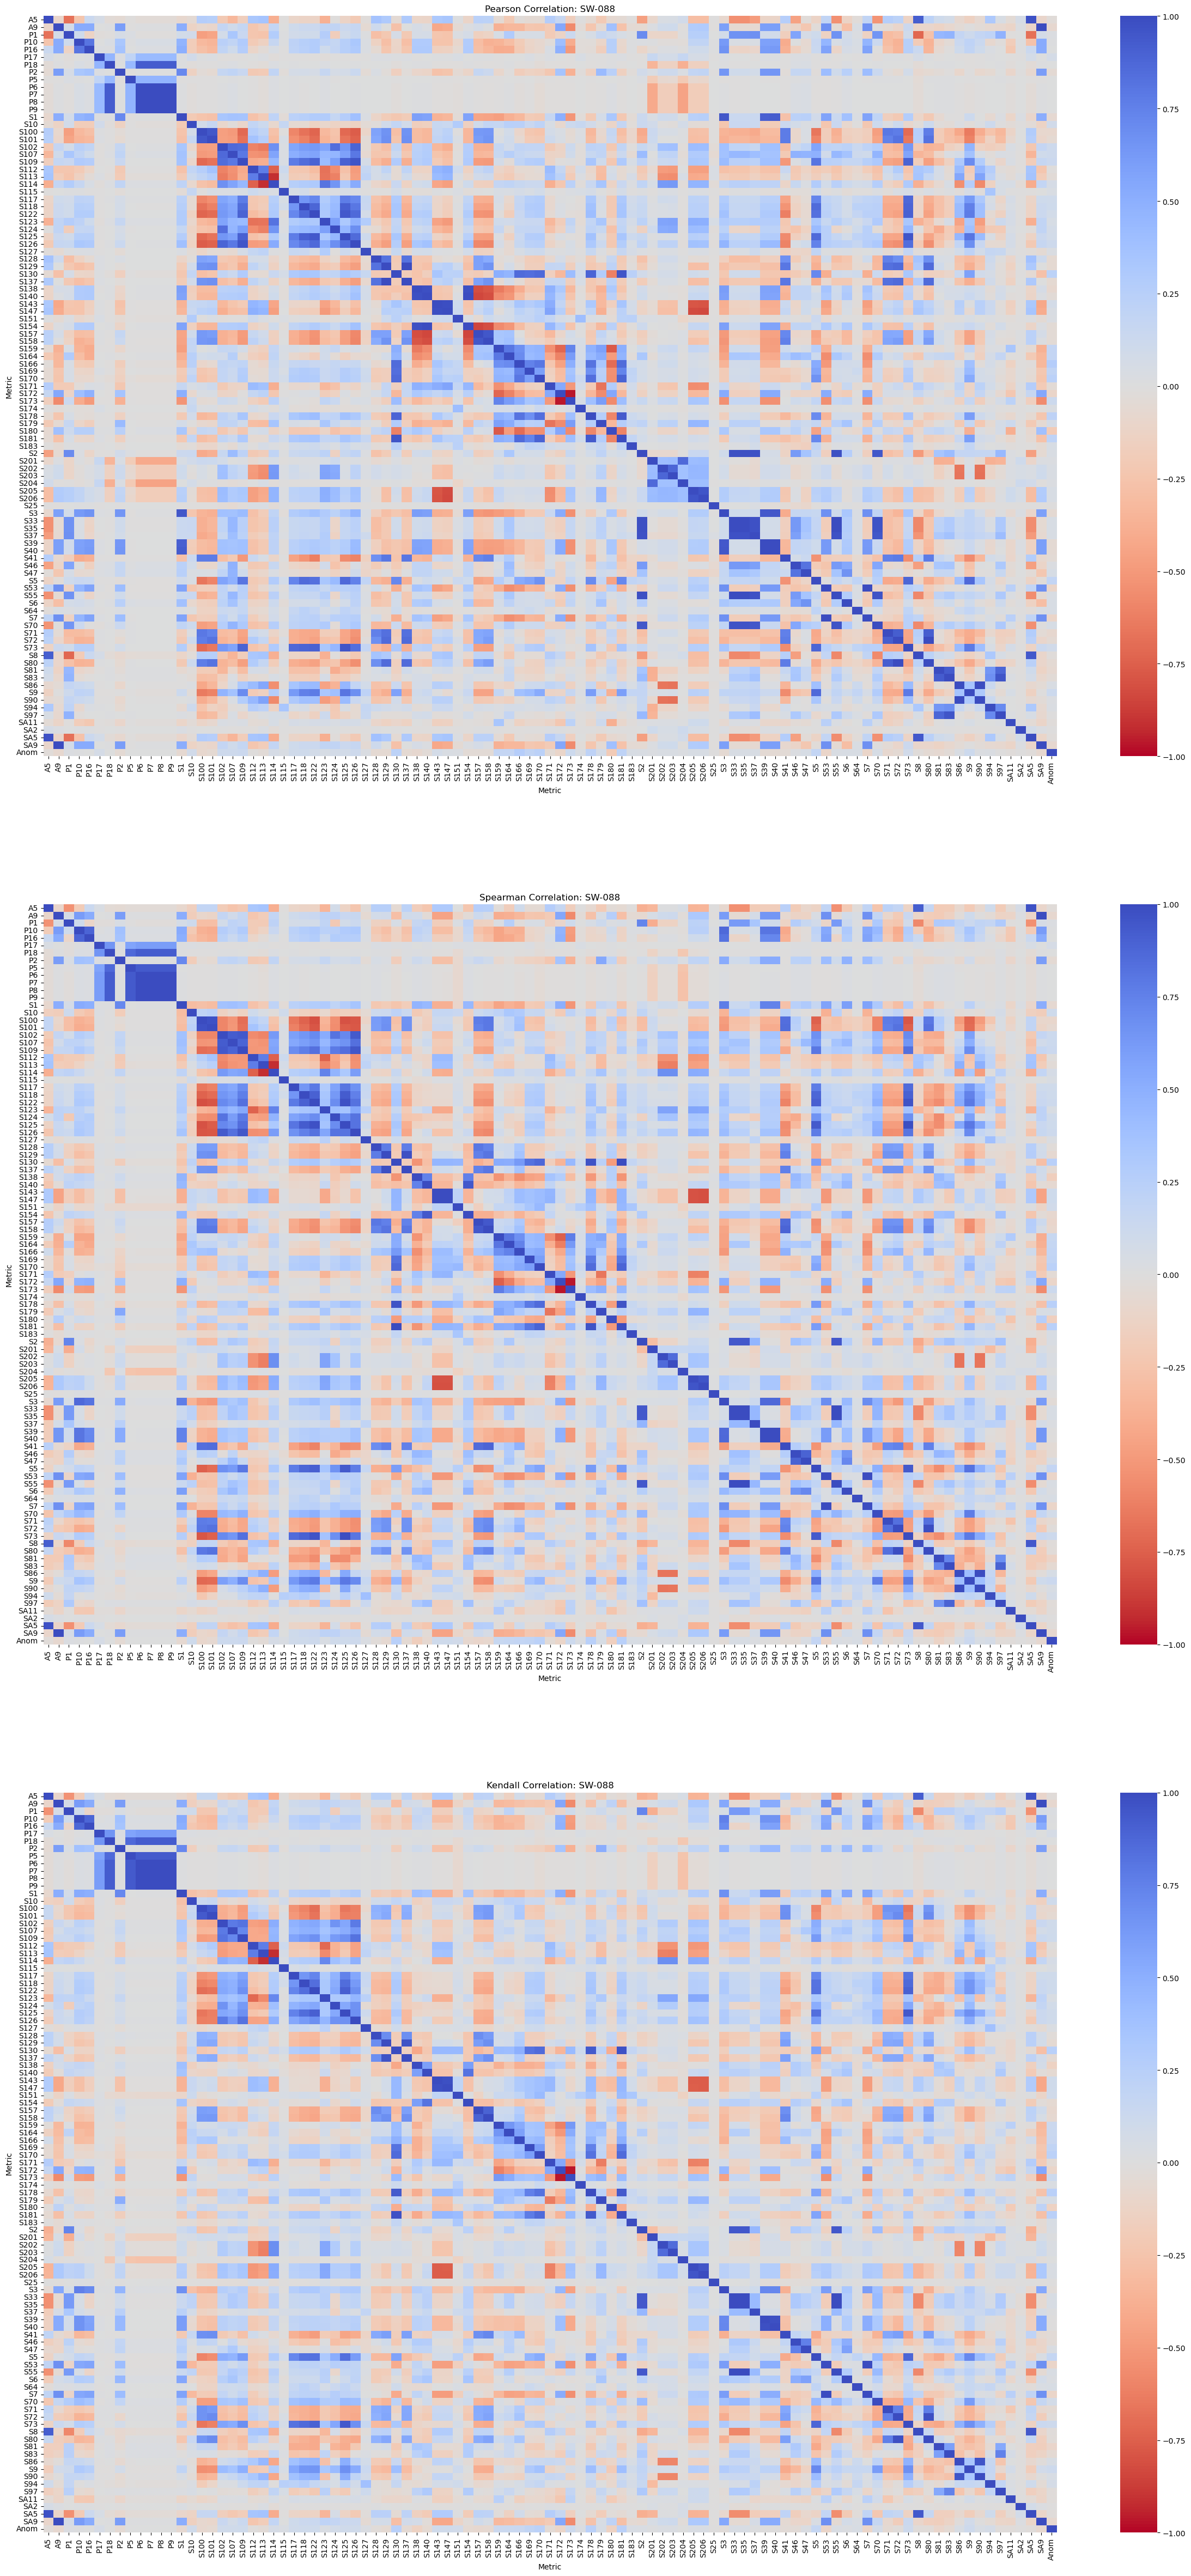

In [275]:
#path = rf'C:\Users\Admin\Documents\GitHub\PhysicsOfData_courses\MAPD_B\Project\Plots\Task_1\whole.html' #{device_name}.html'

#path = f'T1_065_106.html'
#path = 'SW_065.html'

#with performance_report(filename = path):
pearson_dict, spearman_dict, kendall_dict, point_dict = implement_task_1(grouped_df,                                                                         
                                                                            mode = 'device',
                                                                            anomaly_threshold = 4,
                                                                            check_forward_wind = 8,
                                                                            extend_times = 8, 
                                                                            pivot_nparts = 2,
                                                                            corr_threshold = 0.25,
                                                                            plot_graphs = False,
                                                                            plot_heatmap = True,
                                                                            plot_absolute = False,
                                                                            plot_cmap = 0)

In [276]:
metric = ('value', 'Anom')
#metric = 'Anom'
dict_names = ['Pearson', 'Spearman', 'Kendall', 'Point_Biserial']

#path = lambda name: rf'C:\Users\Admin\Documents\GitHub\PhysicsOfData_courses\MAPD_B\Project\Plots\Task_1\{name}.xlsx'
path = lambda name: f'{name}.xlsx'

for pos, d in enumerate([pearson_dict, spearman_dict, kendall_dict, point_dict]):

    name = f'T1_{device_name[3:]}_{metric}_{dict_names[pos]}_Corr'
    d[metric].to_excel(path(name))

    print(f'{dict_names[pos]} Result for {metric}: ')
    display(d[metric])

Pearson Result for ('value', 'Anom'): 


value
                  Anom
      metric          
value Anom    1.000000
      S166    0.266238

Spearman Result for ('value', 'Anom'): 


,,value
,,Anom
,metric,
value,Anom,1.0


Kendall Result for ('value', 'Anom'): 


,,value
,,Anom
,metric,
value,Anom,1.0


Point_Biserial Result for ('value', 'Anom'): 


value
                  Anom
      metric          
value Anom    1.000000
      S166    0.266238

-----------------

## Task 2: Correlation between device loading and temperature

This task involves finding the correlations between a given set of metrics.  We filter the grouped_df to the desired metrics, pivot it and calculate the correlations.  We are interested in finding the Pearson, Spearman and Kendall Correlations.

In [277]:
def plot_corr(pdf_corr, plot_absolute=False, plot_cmap=0):

    #Get correlations using three methods
    corr_mat_pearson = pdf_corr.dropna().astype(float).corr(method='pearson')
    corr_mat_spearman = pdf_corr.dropna().astype(float).corr(method='spearman')
    corr_mat_kendall = pdf_corr.dropna().astype(float).corr(method='kendall')

    if plot_absolute: 
        corr_mat_pearson = abs(corr_mat_pearson)
        corr_mat_spearman = abs(corr_mat_spearman)
        corr_mat_kendall = abs(corr_mat_kendall)
        
        v_min, v_max = 0, 1

    else:
        v_min, v_max = -1, 1

    #Define Colormap
    if plot_cmap == 0: cmap = sns.color_palette("vlag_r", as_cmap=True)
    elif plot_cmap == 1: cmap = sns.color_palette("coolwarm_r", as_cmap=True)
    elif plot_cmap == 2: cmap = sns.color_palette("Blues", as_cmap=True)
    elif plot_cmap == 3: cmap = sns.diverging_palette(20, 220, as_cmap=True)
    else: return ('Invalid Entry: Please choose one of these integers - [0, 1, 2]')

    #Define figure, axes
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    sns.heatmap(corr_mat_pearson, cmap=cmap, ax=ax[0], annot=True, vmin=v_min, vmax=v_max)
    ax[0].set_title(f'Pearson Correlation: {device_name}')

    sns.heatmap(corr_mat_spearman, cmap=cmap, ax=ax[1], annot=True, vmin=v_min, vmax=v_max)
    ax[1].set_title(f'Spearman Correlation: {device_name}')

    sns.heatmap(corr_mat_kendall, cmap=cmap, ax=ax[2], annot=True, vmin=v_min, vmax=v_max)
    ax[2].set_title(f'Kendall Correlation: {device_name}')

    for i in [0, 1, 2]:
        ax[i].set_xlabel('Metric')
        ax[i].set_ylabel('Metric')

    plt.show()

In [278]:
def implement_task_2(grouped_df, mode='device', plot_graph = False, plot_absolute = False, plot_cmap = 3):

    desired_metrics = ["S125", "S181", "S41"]
    if mode not in ['device', 'whole']: return('Invalid Entry: Please enter for mode - ["device", "whole"]')

    print('\nFiltering to desired metrics, grouping and aggregating...')

    if mode == 'whole':       

        #Filter to desired metric, Group by and aggregation wrt hwid
        sample_ind_vals = [[0, 0], ['a', 'b']]
        multi_ind = pd.MultiIndex.from_arrays(sample_ind_vals, names=["when", "metric"])

        func_dict, default_function = get_aggr_funcs()

        grouped2_df = grouped_df.reset_index().query(f'metric in {desired_metrics}').groupby(['when','metric']).apply(lambda x: aggr(x, func_dict, default_function), meta = pd.Series(name = 'value', index = multi_ind)).to_frame()

        #Categorize column for pivoting
        fil_df = grouped2_df.reset_index().categorize(columns='metric')

    else:
        fil_df = grouped_df.reset_index().query(f'metric in {desired_metrics}').categorize(columns='metric')

    print('\nPivoting Dataframe...')
    #Pivot Dataframe
    fil_df_reshaped = dd.reshape.pivot_table(fil_df, index='when', columns='metric', values='value').dropna()

    print('\nComputing to Pandas Dataframe...')
    #Compute to Pandas Dataframe
    pdf_corr = fil_df_reshaped.compute()

    if plot_graph:
        display(fil_df_reshaped.visualize(optimize_graph = True, collapse_outputs = True))

    print('\nPlotting Correlations...')

    #Plot Correlations
    plot_corr(pdf_corr, plot_absolute=plot_absolute, plot_cmap=plot_cmap)



Filtering to desired metrics, grouping and aggregating...

Pivoting Dataframe...

Computing to Pandas Dataframe...


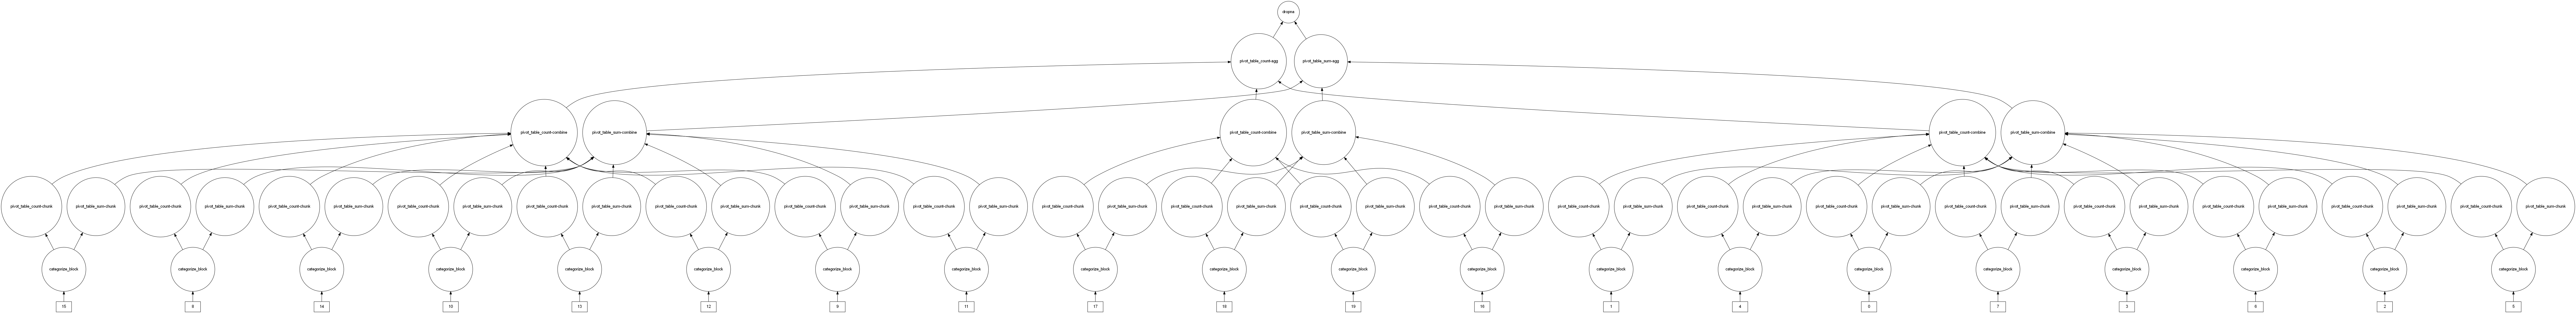


Plotting Correlations...


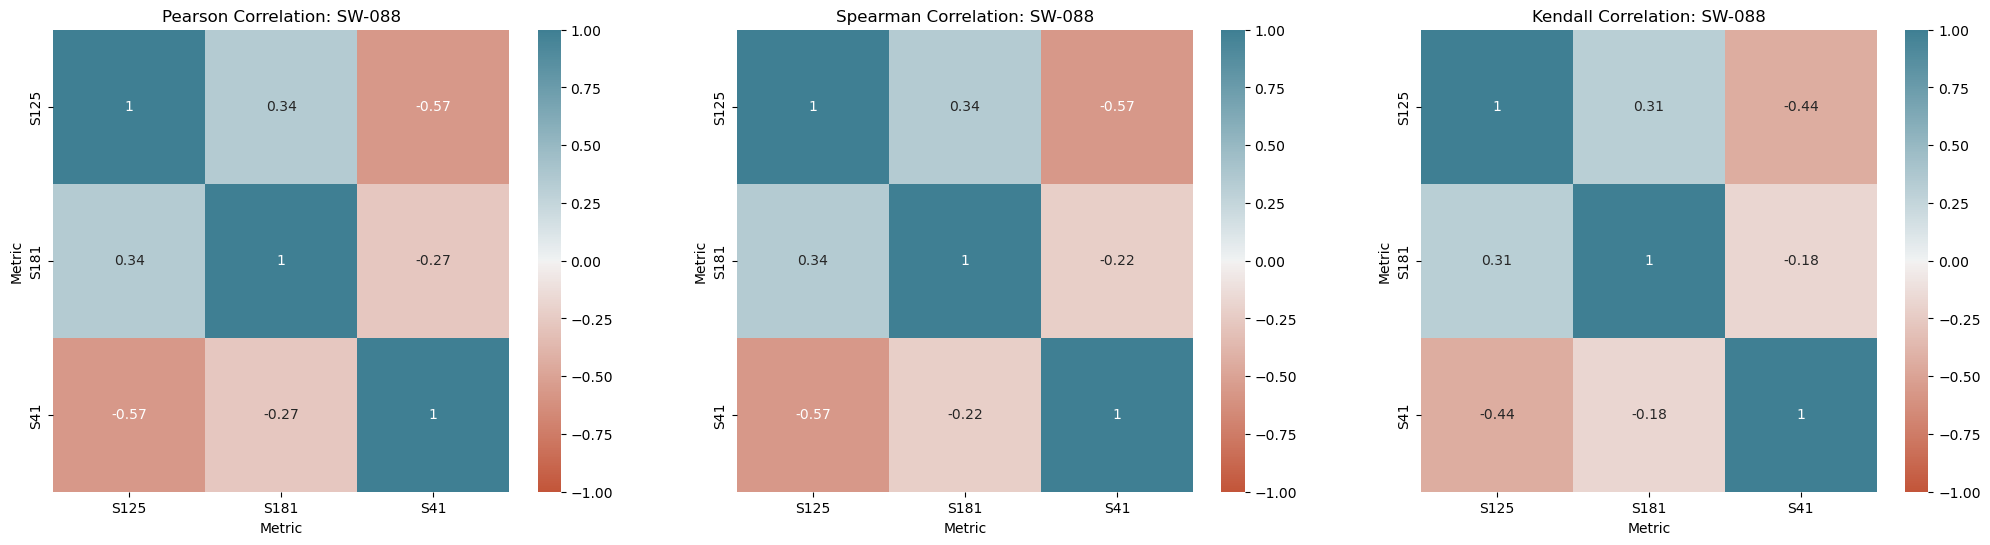

In [279]:
path = rf'C:\Users\Admin\Documents\GitHub\PhysicsOfData_courses\MAPD_B\Project\Plots\Task_2\T2_{device_name}.html'

with performance_report(filename = path):

    implement_task_2(grouped_df, 
                        mode = 'device', 
                        plot_graph = True,
                        plot_absolute = False,
                        plot_cmap = 3)

## Task 3: Predictive Maintanence

The alarms are activated in only one device (SW-088).  Out of a total of 1332 alarm measurements (in the whole data), there are 161 instances where either of the alarms are active, all of which occur in a single device.

- SW-065: 310 measurements, 1 unique value (0)
- SW-088: 522 measurements, 19 unique values, 6 valid values, 161 valid rows
- SW-106: 184 measurements, 1 unique value (0)
- SW-115: 316 measurements, 1 unique value (0)

### Obtaining Correlations

In order to get the correlations with alarms, we start with pivoting the grouped_df, followed by defining a new column that is the logical OR of the two alarm metrics (A5, A9).  This column tells us when either of the alarms are active.  Using this column as our reference, we see which metrics are correlated to it to get an idea of the metrics that influence either of the alarms' activation.

In [321]:
def get_corr_metrics_t3(grouped_df, corr_threshold, mode, pivot_nparts, plot_graph=False, plot_heatmap=False, plot_absolute=False, plot_cmap=0, pandas_mode = True):

    if pandas_mode:

        #Get pivoted dataframe with unvarying metrics removed
        ddf_corr_valid = get_pivoted_pdf(grouped_df,
                                        mode = mode)
        
        #Filter rows with both alarms having NaN values
        ddf_alarms_fil = ddf_corr_valid.dropna(subset=[('value', 'A5'), ('value', 'A9')], how='all')
    
    
        #Replace alarm NaN values with 0
        ddf_alarms_fil.loc[:, ('value', 'A5')] = ddf_alarms_fil.loc[:, ('value', 'A5')].fillna(0)
        ddf_alarms_fil.loc[:, ('value', 'A9')] = ddf_alarms_fil.loc[:, ('value', 'A9')].fillna(0)

        #Drop rows with NaN values in other metrics
        ddf_alarms_valid = ddf_alarms_fil.dropna(how='any')

        #Get valid varying metrics
        check_metrics = ddf_alarms_valid.apply(np.unique, axis=0).apply(lambda x: -1 if len(x[~np.isnan(x)]) > 1 else 0)
        valid_metrics = check_metrics[check_metrics == -1].index

        ddf_alarms_valid = ddf_alarms_valid[valid_metrics]

        #Define new column that is the logical OR of the two alarm columns
        #This lets us keep track of when either of the alarms is active
        ddf_alarms_valid.loc[:, ('value', 'A59')] = ddf_alarms_valid.loc[:, ('value', 'A5')].astype(int) | ddf_alarms_valid.loc[:, ('value', 'A9')].astype(int)
    
    else:
        #Get pivoted dataframe with unvarying metrics removed
        ddf_corr_valid = get_pivoted_ddf(grouped_df, 
                                            pivot_nparts = pivot_nparts,
                                            mode = mode)
    
        #Filter rows with both alarms having NaN values
        ddf_alarms_fil = ddf_corr_valid.dropna(subset=['A5', 'A9'], how='all')
        

        #Replace alarm NaN values with 0
        ddf_alarms_fil['A5'] = ddf_alarms_fil['A5'].fillna(0)
        ddf_alarms_fil['A9'] = ddf_alarms_fil['A9'].fillna(0)

        #Drop rows with NaN values in other metrics
        ddf_alarms_valid = ddf_alarms_fil.dropna(how='any')

        #Remove unvarying metrics after the filtering
        ddf_alarms_valid = get_varying_metrics(ddf_alarms_valid)

        ddf_alarms_valid['A59'] = ddf_alarms_valid['A5'].astype(int) | ddf_alarms_valid['A9'].astype(int)
        ddf_alarms_valid = ddf_alarms_valid.compute()


    if plot_graph and not pandas_mode:
        display(ddf_alarms_valid.visualize(optimize_graph = True, collapse_outputs = True))


    #Obtain the correlations
    print('Obtaining correlations...')
    corr_metrics = ['A59', 'A5', 'A9']
    
    pearson_dict, spearman_dict, kendall_dict, point_dict = get_corr_metrics(ddf_alarms_valid, corr_metrics, corr_threshold, 
                                                                                plot=plot_heatmap, 
                                                                                plot_absolute=plot_absolute, 
                                                                                plot_cmap=plot_cmap,
                                                                                pandas_mode = pandas_mode)
    
    return (ddf_alarms_valid, pearson_dict, spearman_dict, kendall_dict, point_dict)

Obtaining correlations...


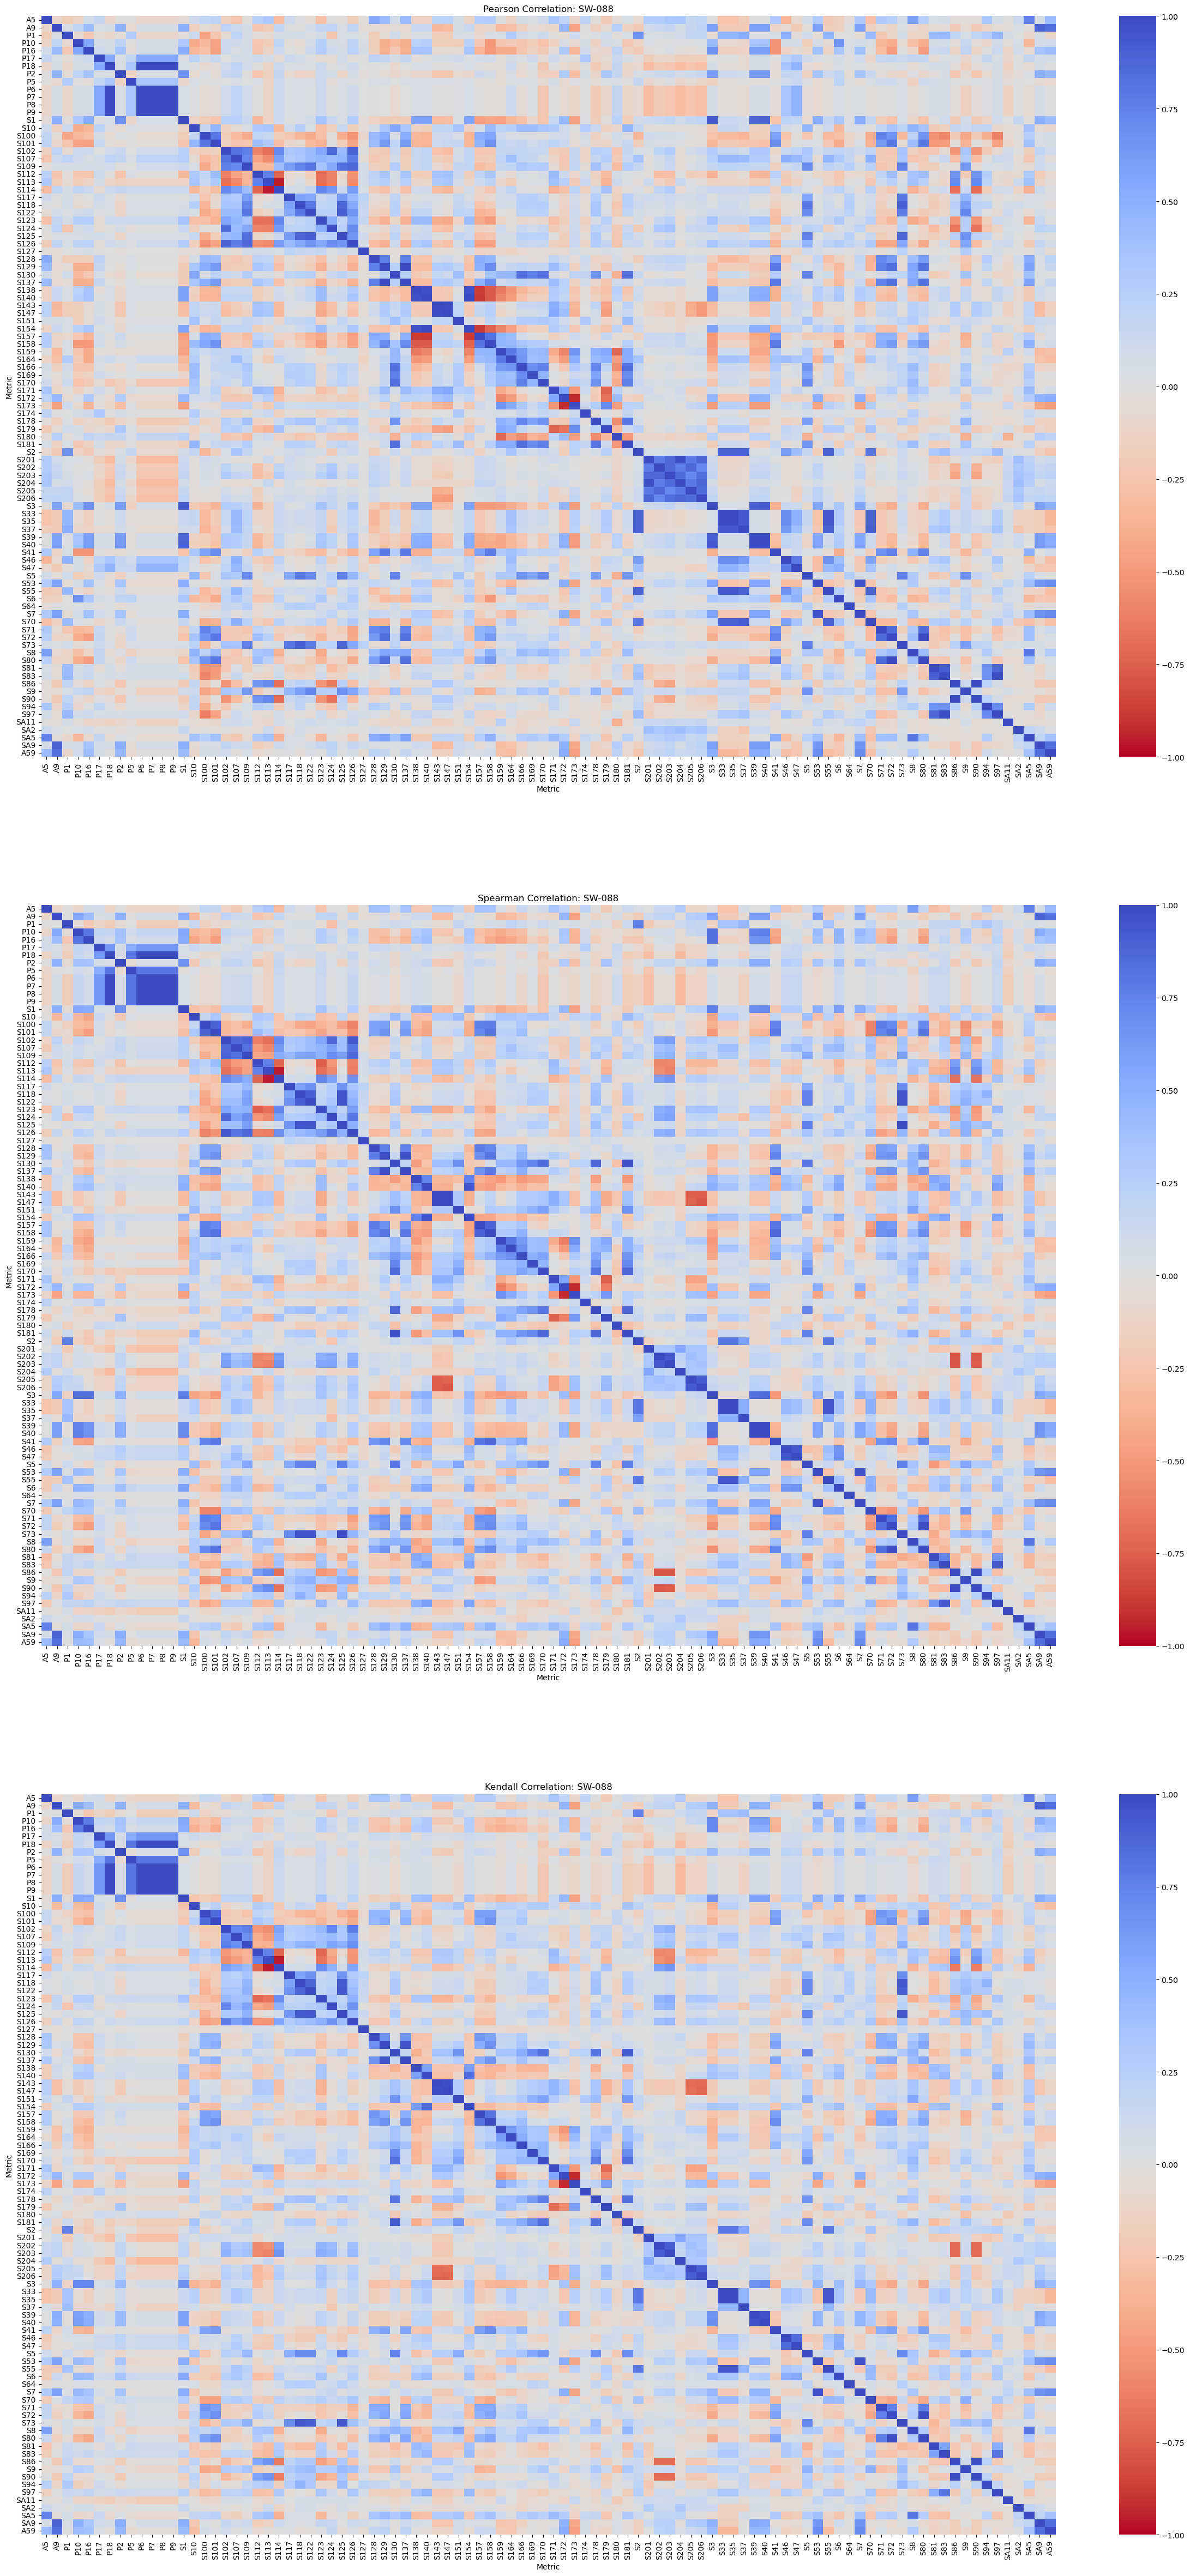

In [322]:
path = rf'C:\Users\Admin\Documents\GitHub\PhysicsOfData_courses\MAPD_B\Project\Plots\Task_3\{device_name}.html'

with performance_report(filename = path):

    pdf_valid, pearson_dict, spearman_dict, kendall_dict, point_dict = get_corr_metrics_t3(grouped_df, 
                                                                                corr_threshold = 0.5,
                                                                                mode = 'device',
                                                                                pivot_nparts = 8,
                                                                                plot_graph = False,
                                                                                plot_heatmap = True,
                                                                                plot_absolute = False,
                                                                                plot_cmap = 0,
                                                                                pandas_mode = True)

In [ ]:
metric = 'A59'
dict_names = ['Pearson', 'Spearman', 'Kendall', 'Point_Biserial']
dicts = [pearson_dict, spearman_dict, kendall_dict, point_dict]

for i, d in enumerate(dicts):
    print(f'\n {dict_names[i]}')
    display(d['A59'])

In [324]:
metric = ('value', 'A59')
#metric = 'A59'
dict_names = ['Pearson', 'Spearman', 'Kendall', 'Point_Biserial']

path = lambda name: rf'C:\Users\Admin\Documents\GitHub\PhysicsOfData_courses\MAPD_B\Project\Plots\Task_3\{name}.xlsx'

for pos, d in enumerate([pearson_dict, spearman_dict, kendall_dict, point_dict]):

    name = f'T3_{device_name[3:]}_{metric}_{dict_names[pos]}'
    d[metric].to_excel(path(name))

    print(f'{dict_names[pos]} Result for {metric}: ')
    display(d[metric])

Pearson Result for ('value', 'A59'): 


value
                   A59
      metric          
value A59     1.000000
      SA9     0.840873
      A9      0.830326
      S7      0.707179
      S53     0.695330
      S172    0.527290
      S39     0.525779
      S40     0.521872
      S3      0.500721

Spearman Result for ('value', 'A59'): 


value
                   A59
      metric          
value A59     1.000000
      SA9     0.840873
      A9      0.830326
      S7      0.707179
      S53     0.695330
      S39     0.535609
      S40     0.529857
      S172    0.527290

Kendall Result for ('value', 'A59'): 


value
                   A59
      metric          
value A59     1.000000
      SA9     0.840873
      A9      0.830326
      S7      0.707179
      S53     0.695330
      S172    0.527290

Point_Biserial Result for ('value', 'A59'): 


value
                   A59
      metric          
value A59     1.000000
      SA9     0.840873
      A9      0.830326
      S7      0.707179
      S53     0.695330
      S172    0.527290
      S39     0.525779
      S40     0.521872
      S3      0.500721

### Predicting Alarm

To predict an alarm, we utilize the highly correlated variables from the Pearson Correlation.  

- Obtaining Weights: Each of these metrics is given a weight, which is proportional to its correlation value. 

- Setting Threshold: A threshold is defined for each of the metrics by consider the mean values when the alarm is zero and one.  These values give us a sense of where each metric stays depending on the alarm's value.  Taking the mean of these two gives us a border/threshold, using which we can predict if the alarm is going to be activated.  This is possible since we are dealing with Pearson Correlation, which checks for linear correlations.

- Prediction Function:  Using the weights and thresholds, we can predict an alarm using weights of the metrics that surpassed the thresholds.  The summation of these weights will give us a probability of the alarm being active.

##### Obtaining Weights for prediction

In [400]:
def get_weights(corr_dict, pandas_mode = True):
    #Metric to be correlated against
    if pandas_mode:
        metric = ('value', 'A59')
        drop_metrics = np.array(['A59', 'A5', 'A9'])

        #Define dataframe with highly correlated metrics using Pearson correlation
        corr_metrics = corr_dict[metric]

        corr_new = corr_dict[('value', 'A59')].stack()
        corr_metrics = corr_new.reset_index().drop(columns = ['level_0', 'level_2']).set_index('metric')

        check_drop = [metric in corr_metrics.index for metric in drop_metrics]
        drop_metrics = drop_metrics[check_drop]

        corr_metrics = corr_metrics.drop(drop_metrics)  #Drop the alarm metrics

        corr_metrics = corr_metrics[abs(corr_metrics['value']) > 0.5]   #Filter to correlations greater than 0.5

        #Define weights wrt correlations
        corr_metrics['Weights'] = abs(corr_metrics['value'])/sum(abs(corr_metrics['value']))  

        #Rename Columns
        corr_metrics.columns = ['Pearson', 'Weights']

    else:
        metric = 'A59'
        drop_metrics = np.array(['A59', 'A5', 'A9'])

        #Define dataframe with highly correlated metrics using Pearson correlation
        corr_metrics = corr_dict[metric]

        #Check for alarm metrics present and drop them    
        check_drop = [metric in corr_metrics.index for metric in drop_metrics]
        drop_metrics = drop_metrics[check_drop]

        corr_metrics = corr_metrics.drop(drop_metrics)  #Drop the alarm metrics

        corr_metrics = corr_metrics[abs(corr_metrics[metric]) > 0.5]   #Filter to correlations greater than 0.5

        #Define weights wrt correlations
        corr_metrics['Weights'] = abs(corr_metrics[metric])/sum(abs(corr_metrics[metric]))  

        #Rename Columns
        corr_metrics.columns = ['Pearson', 'Weights']
    
    return(corr_metrics)

In [401]:
corr_metrics = get_weights(pearson_dict, pandas_mode = True)
corr_metrics

,Pearson,Weights
metric,,
SA9,0.840873,0.194690
S7,0.707179,0.163735
S53,0.695330,0.160992
S172,0.527290,0.122085
S39,0.525779,0.121735
S40,0.521872,0.120830
S3,0.500721,0.115933


##### Setting Threshold, Prediction Function

In [458]:
def get_pred_outline(pdf_valid, corr_metrics, metric, pandas_mode = True):

    ## Setting Thresholds

    #Filter pdf_valid to only highly correlated metrics
    corr_metrics_list = list(corr_metrics.index) + ['A59']
    metric = 'A59'
    
    if pandas_mode:
        corr_metrics_list = [('value', metric) for metric in corr_metrics_list]
        pdf_corr = pdf_valid[corr_metrics_list]

        metric = ('value', 'A59')

        #Get separate dataframes for each case of alarm
        pdf_corr_1 = pdf_corr[pdf_corr[metric] == 1]
        pdf_corr_0 = pdf_corr[pdf_corr[metric] == 0]

        #Get mean values of each metric in each case
        metric_mean_1 = pdf_corr_1.mean(axis=0)
        metric_mean_0 = pdf_corr_0.mean(axis=0)

        #Define thresholds as the mean of the above
        thresholds = (metric_mean_1 + metric_mean_0)/2
        thresholds = thresholds.reset_index().drop(columns = ['level_0']).set_index('metric').squeeze()

    else:

        pdf_corr = pdf_valid[corr_metrics_list]

        #Get separate dataframes for each case of alarm
        pdf_corr_1 = pdf_corr[pdf_corr[metric] == 1]
        pdf_corr_0 = pdf_corr[pdf_corr[metric] == 0]

        #Get mean values of each metric in each case
        metric_mean_1 = pdf_corr_1.mean(axis=0)
        metric_mean_0 = pdf_corr_0.mean(axis=0)

        #Define thresholds as the mean of the above
        thresholds = (metric_mean_1 + metric_mean_0)/2
        thresholds = thresholds.drop(metric)

    ## Obtaining prediction outline dataframe
    #Dataframe used as reference to make predictions
    pred_outline = pd.DataFrame({'corr' : corr_metrics['Pearson'],
                                        'weights': corr_metrics['Weights'],
                                            'threshold': thresholds,
                                            })
    
    pred_outline = pred_outline.drop('A59')

    return(pred_outline)  

In [459]:
pred_outline = get_pred_outline(pdf_valid, corr_metrics, metric = 'A59', pandas_mode = True)
pred_outline

,corr,weights,threshold
metric,,,
S172,0.527290,0.122085,0.670094
S3,0.500721,0.115933,178.839948
S39,0.525779,0.121735,191.013921
S40,0.521872,0.120830,190.094907
S53,0.695330,0.160992,0.645270
S7,0.707179,0.163735,0.638514
SA9,0.840873,0.194690,0.446240


In [460]:
#Prediction Function
def get_prediction(new_vals, pdf_outline, perc_threshold=75, show_pdf=True):

    pred = pdf_outline.copy()
    pred['new_vals'] = new_vals

    #Defining new column which checks if the threshold is surpassed
    pred['check'] = pred.apply(lambda row: row['new_vals'] > row['threshold'] if row['corr'] > 0 else row['new_vals'] < row['threshold'], axis=1)

    #Defining new column which is the weights of the metrics that surpassed the thresholds
    pred['weighted_check'] = pred['weights'] * pred['check']

    if show_pdf: display(pred)

    #Gets the percentage for the alarm to be active
    alarm_one_perc = sum(pred['weighted_check']) * 100
    print('Probability Percentage for alarm A9 to be active: ', round(alarm_one_perc, 3), '%')

    if alarm_one_perc >= perc_threshold: return(1)
    return(0)

##### Prediction with new values

In [461]:
new_metric_vals = pd.Series({ 'SA9': 1.0, 
                                'S7': 0.0, 
                                'S53': 1.0, 
                                'S39': 200.0, 
                                'S172': 1.0,
                                'S40': 145.0
                                })
new_metric_vals

SA9       1.0
S7        0.0
S53       1.0
S39     200.0
S172      1.0
S40     145.0
dtype: float64

In [462]:
perc_threshold = 75

prediction = get_prediction(new_vals = new_metric_vals, 
                            pdf_outline = pred_outline, 
                            perc_threshold = perc_threshold, 
                            show_pdf=True)

print('\nThreshold: ', perc_threshold/100)
print('Alarm Value Prediction: ', prediction)

,corr,weights,threshold,new_vals,check,weighted_check
metric,,,,,,
S172,0.527290,0.122085,0.670094,1.0,True,0.122085
S3,0.500721,0.115933,178.839948,NaN,False,0.000000
S39,0.525779,0.121735,191.013921,200.0,True,0.121735
S40,0.521872,0.120830,190.094907,145.0,False,0.000000
S53,0.695330,0.160992,0.645270,1.0,True,0.160992
S7,0.707179,0.163735,0.638514,0.0,False,0.000000
SA9,0.840873,0.194690,0.446240,1.0,True,0.194690


Probability Percentage for alarm A9 to be active:  59.95 %

Threshold:  0.75
Alarm Value Prediction:  0


## Close Cluster

In [ ]:
cluster.close()
client.close()